In [12]:
from plate_detection.blocks import YoloV3
import tensorflow as tf
from plate_detection.yolo.const import YOLO_LAYERS, NUM_CLASSES
from plate_detection.yolo.utils import load_yolo_weights, load_image_as_tf, get_bboxes

/home/malik/.cache/pypoetry/virtualenvs/license-plate-recognition-E7j_m8ey-py3.10/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'DarkNet_Conv2D_0', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/malik/.cache/pypoetry/virtualenvs/license-plate-recognition-E7j_m8ey-py3.10/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'DarkNet_Residual_1_Conv2D1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.

Model: "YoloV3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 416, 416,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Conv2D_0    │ (None, 416, 416,  │        992 │ input[0][0]       │
│ (CNNBlock)          │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Conv2D_1    │ (None, 208, 208,  │     18,688 │ DarkNet_Conv2D_0… │
│ (CNNBlock)          │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Residual_1  │ (None, 208, 208,  │     20,864 │ DarkNet_Conv2D_1… │
│ (ResidualBlock)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Conv2D_2    │ (None, 104, 104,  │     74,240 │ DarkNet_Residual… │
│ (CNNBlock)          │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Residual_2  │ (None, 104, 104,  │    165,376 │ DarkNet_Conv2D_2… │
│ (ResidualBlock)     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Conv2D_3    │ (None, 52, 52,    │    295,936 │ DarkNet_Residual… │
│ (CNNBlock)          │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Residual_s… │ (None, 52, 52,    │  2,633,728 │ DarkNet_Conv2D_3… │
│ (ResidualBlock)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Conv2D_4    │ (None, 26, 26,    │  1,181,696 │ DarkNet_Residual… │
│ (CNNBlock)          │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Residual_s… │ (None, 26, 26,    │ 10,510,336 │ DarkNet_Conv2D_4… │
│ (ResidualBlock)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Conv2D_5    │ (None, 13, 13,    │  4,722,688 │ DarkNet_Residual… │
│ (CNNBlock)          │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DarkNet_Residual_3  │ (None, 13, 13,    │ 20,996,096 │ DarkNet_Conv2D_5… │
│ (ResidualBlock)     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Yolo_Conv2D_0       │ (None, 13, 13,    │    526,336 │ DarkNet_Residual… │
│ (CNNBlock)          │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Yolo_Conv2D_1       │ (None, 13, 13,    │  4,722,688 │ Yolo_Conv2D_0[0]… │
│ (CNNBlock)          │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Yolo_Residual_1     │ (None, 13, 13,    │  5,249,024 │ Yolo_Conv2D_1[0]… │
│ (ResidualBlock)     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Yolo_Conv2D_2       │ (None, 13, 13,    │    526,336 │ Yolo_Residual_1[… │
│ (CNNBlock)          │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Yolo_Conv2D_3       │ (None, 13, 13,    │    132,096 │ Yolo_Conv2D_2[0]

 Total params: 61,576,342 (234.90 MB)

 Trainable params: 61,523,734 (234.69 MB)

 Non-trainable params: 52,608 (205.50 KB)

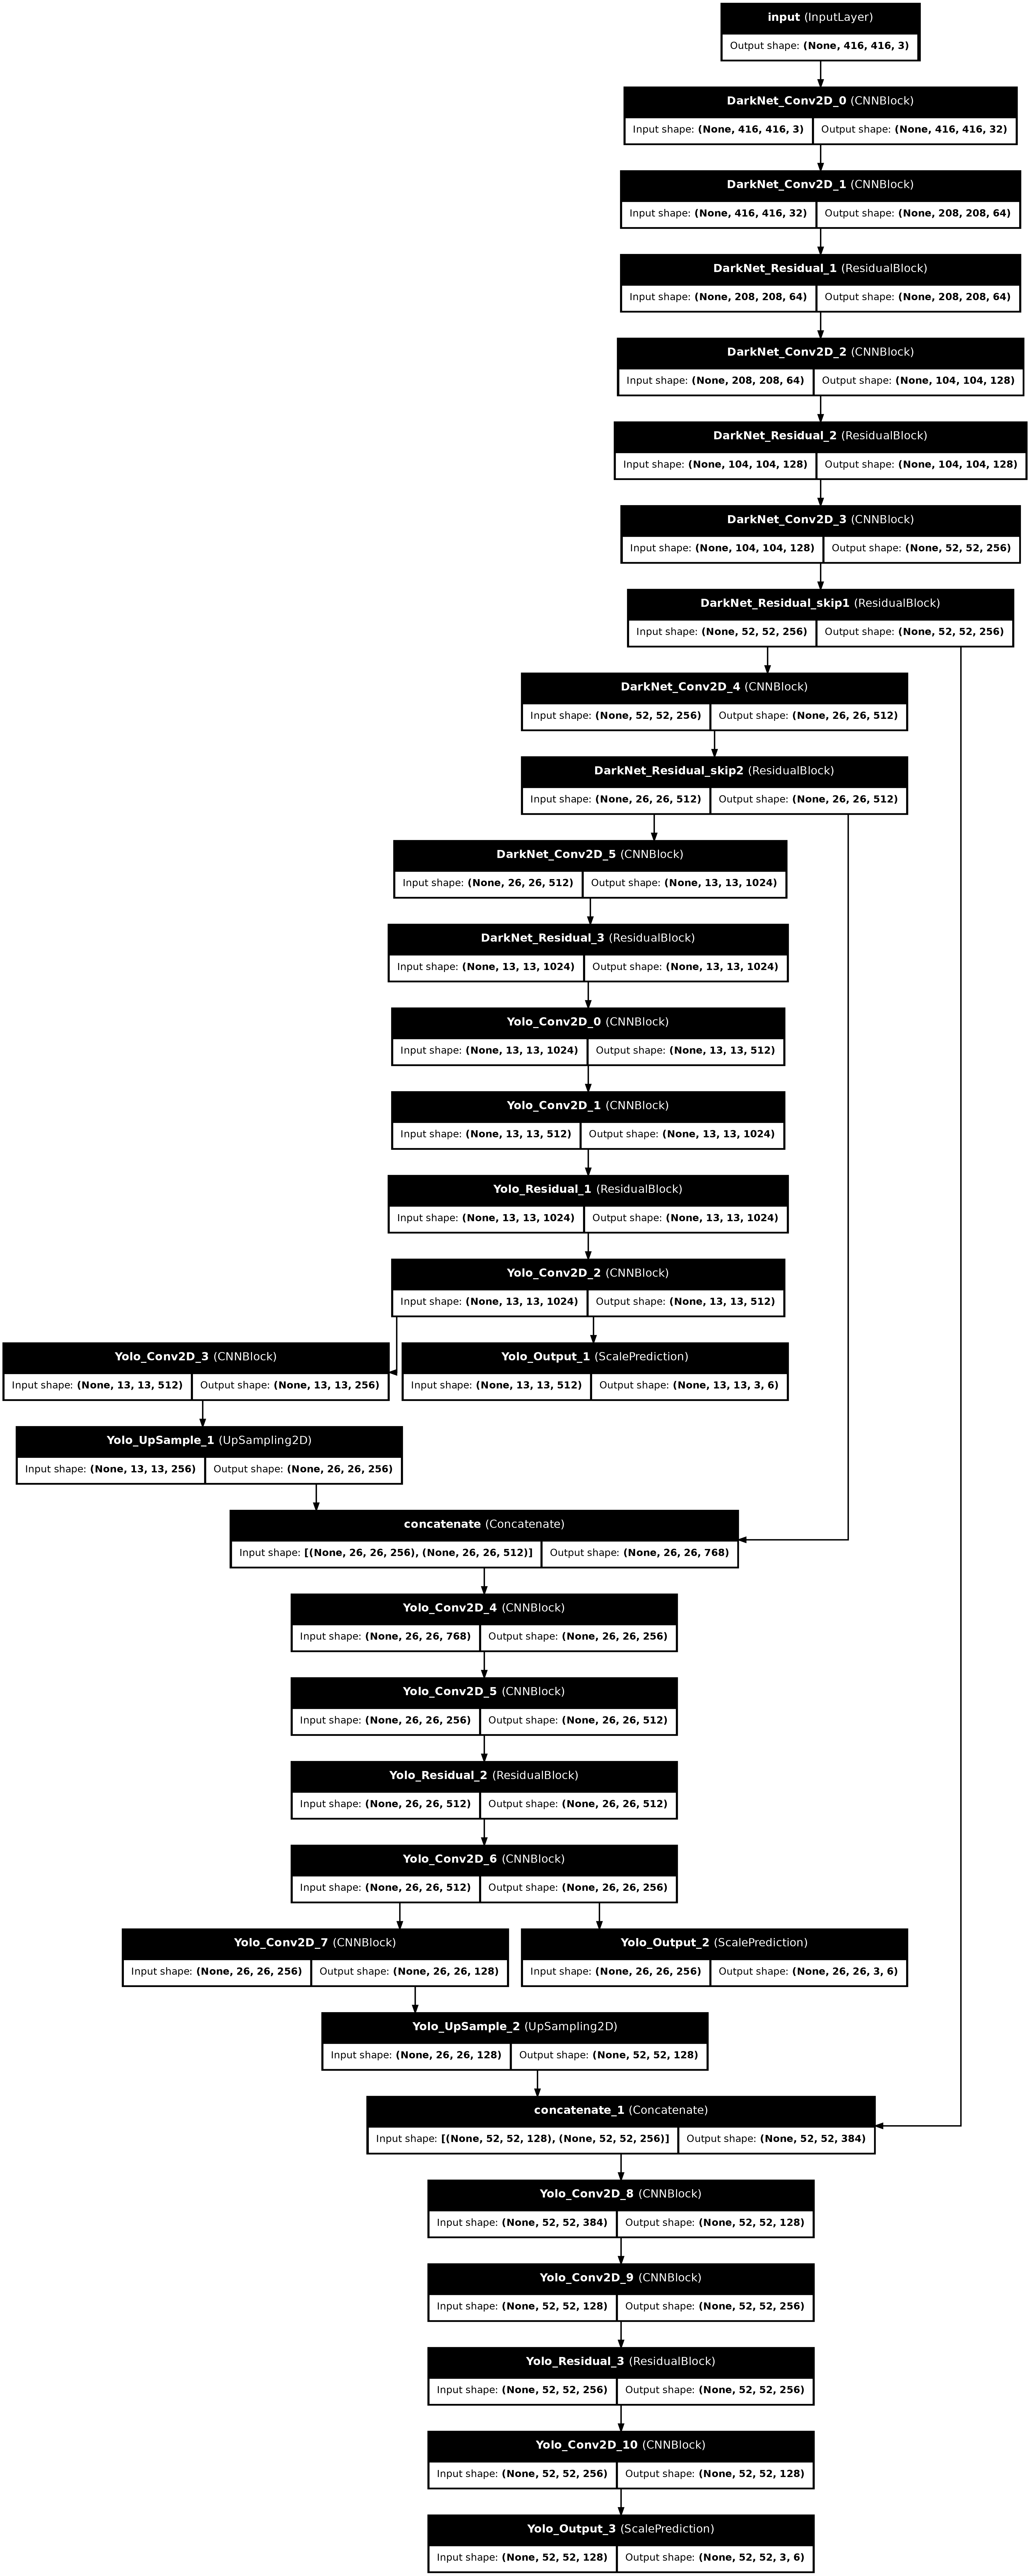

In [13]:
model = YoloV3(num_classes=NUM_CLASSES)()
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [3]:
layers = load_yolo_weights("yolov3-custom_final.weights", model, YOLO_LAYERS)

Successfull data write


In [4]:
image = load_image_as_tf("/home/malik/projects/license-plate-recognition/plate_detection/cars-in-poland.jpg")

out = model(image)

In [5]:
detections = get_bboxes(out)
detections

tf.Tensor(
[[1.         0.         0.63992053]
 [0.         1.         0.        ]
 [0.63992053 0.         1.        ]], shape=(3, 3), dtype=float32)
Before condition tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
condition tf.Tensor([False False  True], shape=(3,), dtype=bool)
After condition tf.Tensor([ True  True False], shape=(3,), dtype=bool)
Before condition tf.Tensor([ True  True False], shape=(3,), dtype=bool)
condition tf.Tensor([False False False], shape=(3,), dtype=bool)
After condition tf.Tensor([ True  True False], shape=(3,), dtype=bool)


(array([[240, 353, 277, 366],
        [115, 322, 146, 335]], dtype=int32),
 array([0, 0], dtype=int32),
 array([0.90906554, 0.88810617], dtype=float32))

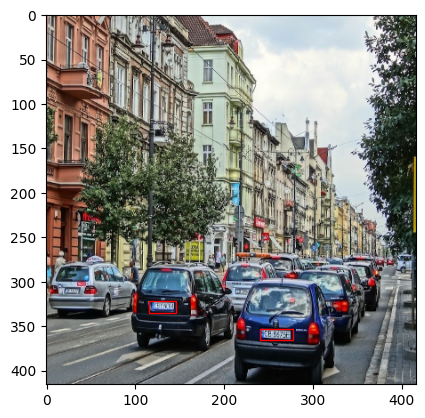

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


fig, ax = plt.subplots()

# Display the image
ax.imshow(tf.squeeze(image))

boxes, _class, conf = detections
for box in boxes:
    # Get the bounding box coordinates
    x1, y1, x2, y2 = box

    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    # Add the rectangle to the Axes
    ax.add_patch(rect)

# # Show the plot with the rectangle
plt.show()